## Train QuickNAT
Working code! Details coming soon!

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.data_utils import get_imdb_data

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
train_data, test_data = get_imdb_data()
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

(3240, 256, 256)
27.0
0.0
Train size: 1890
Test size: 1350


In [56]:
from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.solver import Solver


train_loader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False, num_workers=4)

param ={
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_class':28,
        'se_block' : True,
        'drop_out' : 0.2
    }

exp_dir_name = 'Exp02_try3'

quicknat_model = quickNAT(param)
solver = Solver(optim_args={"lr": 1e-2})
solver.train(quicknat_model, train_loader, val_loader, log_nth=1, num_epochs=1, exp_dir_name=exp_dir_name)

START TRAIN.


/home/masterthesis/shayan/quickNat_pytorch/quickNat_pytorch/net_api/losses.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input_soft = F.softmax(input)


[Iteration : 0] : 5.210541725158691
[Iteration : 50] : 1.2433829307556152
[Iteration : 100] : 1.161158800125122
[Iteration : 150] : 1.1895557641983032
[Iteration : 200] : 1.1753301620483398
[Iteration : 250] : 1.1796491146087646
[Iteration : 300] : 1.4264402389526367
[Iteration : 350] : 1.266700029373169
[Iteration : 400] : 1.136527180671692
[Iteration : 450] : 1.2723677158355713
[Iteration : 500] : 1.051438808441162
[Iteration : 550] : 1.0283063650131226
[Iteration : 600] : 0.979261040687561
[Iteration : 650] : 1.0447484254837036
[Iteration : 700] : 0.9711078405380249
[Iteration : 750] : 0.8968095779418945
[Iteration : 800] : 1.0184016227722168
[Iteration : 850] : 0.7976891398429871
[Iteration : 900] : 0.8572952747344971
[Epoch : 0/1] : 0.8587087392807007
Saving model... models/Exp02_try3/quicknat_epoch1.model
FINISH.


## Save the Model

When you are satisfied with your training, you can save the model.

In [11]:
quicknat_model.save("Exp02_try3/quicknat_model.model")

Saving model... models/Exp02_try3/quicknat_model.model


# Deploy Model on Test Data

In [5]:
test_data.X.shape

(1350, 1, 256, 256)

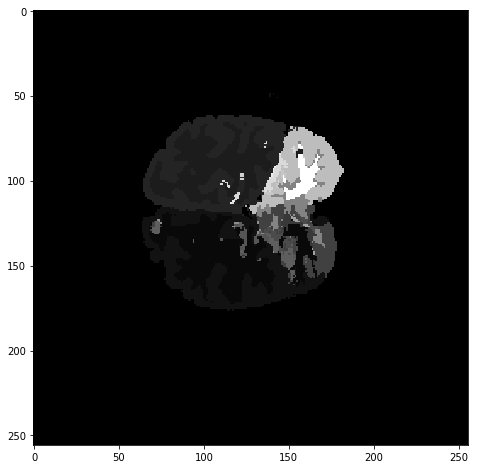

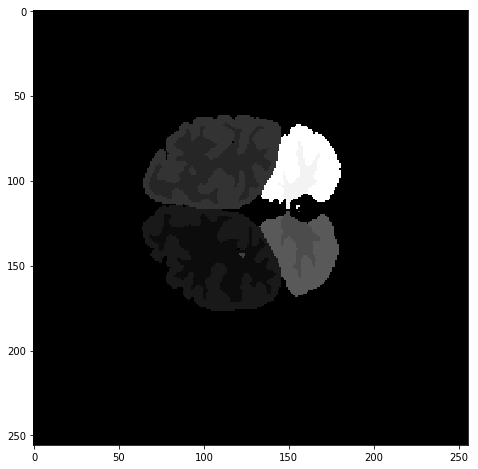

In [57]:
import matplotlib.pyplot as plt

quick_model = torch.load('models/Exp02_try3/quicknat_epoch1.model')
quick_model = quick_model.eval()
with torch.no_grad():
    test_input = Variable(torch.Tensor(test_data.X[200:201]).cuda())
quick_model.enable_test_dropout()
out = quick_model(test_input)
max_val, idx = torch.max(out,1)
idx = idx.data.cpu().numpy()
idx = np.squeeze(idx)
plt.imshow(idx)
plt.show()

img_test = test_data.y[200:201]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.show()